<a href="https://www.kaggle.com/code/suryateja35/30day-sales-forecast?scriptVersionId=213020019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
file_path = '/kaggle/input/sales-transaction/Sales_transaction_gross_sales.csv'
sales_data = pd.read_csv(file_path)

In [3]:
# Convert 'TRANSACTION_DATE' to datetime format
sales_data['TRANSACTION_DATE'] = pd.to_datetime(sales_data['TRANSACTION_DATE'])

In [4]:
# Remove rows with negative sales values
sales_data = sales_data[sales_data['ESTIMATED_GROSS_PROFIT_AMOUNT'] >= 0]

In [5]:
# Aggregate data by day to ensure one entry per day
daily_sales = sales_data.groupby('TRANSACTION_DATE')['ESTIMATED_GROSS_PROFIT_AMOUNT'].sum().reset_index()
print(daily_sales)

     TRANSACTION_DATE  ESTIMATED_GROSS_PROFIT_AMOUNT
0          2020-01-02                       19759.60
1          2020-01-03                       17195.57
2          2020-01-05                       17485.47
3          2020-01-06                       22110.86
4          2020-01-07                       14211.80
...               ...                            ...
1589       2024-12-02                      767568.56
1590       2024-12-03                      534608.51
1591       2024-12-04                      530186.29
1592       2024-12-05                      532576.96
1593       2024-12-06                        1117.94

[1594 rows x 2 columns]


In [6]:
# Generate a continuous date range
date_range = pd.date_range(start=daily_sales['TRANSACTION_DATE'].min(), 
                           end=daily_sales['TRANSACTION_DATE'].max())
print(date_range)

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30',
               '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06'],
              dtype='datetime64[ns]', length=1801, freq='D')


In [7]:
missing_dates = pd.date_range(start=daily_sales['TRANSACTION_DATE'].min(), 
                              end=daily_sales['TRANSACTION_DATE'].max()).difference(daily_sales['TRANSACTION_DATE'])
print(f"Missing dates before reindexing: {missing_dates}")

Missing dates before reindexing: DatetimeIndex(['2020-01-04', '2020-01-11', '2020-01-18', '2020-01-25',
               '2020-02-01', '2020-02-08', '2020-02-15', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2024-09-29', '2024-10-05', '2024-10-12', '2024-10-19',
               '2024-10-26', '2024-11-02', '2024-11-09', '2024-11-16',
               '2024-11-17', '2024-11-24'],
              dtype='datetime64[ns]', length=207, freq=None)


In [8]:
missing_dates_df = pd.DataFrame({'Missing Dates': missing_dates})
print(missing_dates_df.head(10))  # Check the first 10 missing dates

# Check the day of the week for missing dates
missing_dates_df['Day of Week'] = missing_dates_df['Missing Dates'].dt.day_name()
print(missing_dates_df['Day of Week'].value_counts())


  Missing Dates
0    2020-01-04
1    2020-01-11
2    2020-01-18
3    2020-01-25
4    2020-02-01
5    2020-02-08
6    2020-02-15
7    2020-02-22
8    2020-02-23
9    2020-02-24
Day of Week
Saturday    176
Sunday       21
Monday        6
Friday        3
Tuesday       1
Name: count, dtype: int64


In [9]:
#Merge with the full date range, filling missing dates with 0
daily_sales = daily_sales.set_index('TRANSACTION_DATE').reindex(date_range, fill_value=0).reset_index()
daily_sales.rename(columns={'index': 'ds', 'ESTIMATED_GROSS_PROFIT_AMOUNT': 'y'}, inplace=True)


In [10]:
import numpy as np
daily_sales['y'] = daily_sales['y'].replace(0, np.nan)  # Replace zeros (only for weekdays) with NaN
daily_sales['y'] = daily_sales['y'].interpolate(method='linear')  # Linear interpolation for missing values
daily_sales['y'] = daily_sales['y'].fillna(0)  # Fill remaining NaNs (e.g., weekends) with 0

In [11]:
# Identify and cap outliers
q1 = daily_sales['y'].quantile(0.25)
q3 = daily_sales['y'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Replace outliers with the bounds
daily_sales['y'] = daily_sales['y'].clip(lower=lower_bound, upper=upper_bound)


In [12]:
daily_sales['y'] = np.log1p(daily_sales['y'])
model = Prophet()
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.fit(daily_sales)

11:24:01 - cmdstanpy - INFO - Chain [1] start processing
11:24:02 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#Forecast the next 3 months (90 days)
future_dates = model.make_future_dataframe(periods=30)  # Add 90 days to the time series
forecast = model.predict(future_dates)

In [14]:
forecast.to_csv("/kaggle/working/sales_forecast_corrected.csv", index=False)
print("Forecast saved as 'sales_forecast_corrected.csv'.")

Forecast saved as 'sales_forecast_corrected.csv'.


             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2020-01-02  10.025129    8.700280   11.458700    10.025129    10.025129   
1    2020-01-03  10.028204    8.625448   11.388239    10.028204    10.028204   
2    2020-01-04  10.031279    7.584095   10.367409    10.031279    10.031279   
3    2020-01-05  10.034355    7.756458   10.484823    10.034355    10.034355   
4    2020-01-06  10.037430    9.271697   11.989079    10.037430    10.037430   
...         ...        ...         ...         ...          ...          ...   
1826 2025-01-01  10.787726    9.494323   12.311546    10.787219    10.788419   
1827 2025-01-02  10.787400    9.495830   12.324797    10.786786    10.788205   
1828 2025-01-03  10.787074    9.556379   12.211320    10.786391    10.787959   
1829 2025-01-04  10.786748    8.257746   11.061061    10.785970    10.787682   
1830 2025-01-05  10.786422    8.521304   11.208400    10.785446    10.787477   

      additive_terms  additive_terms_lo

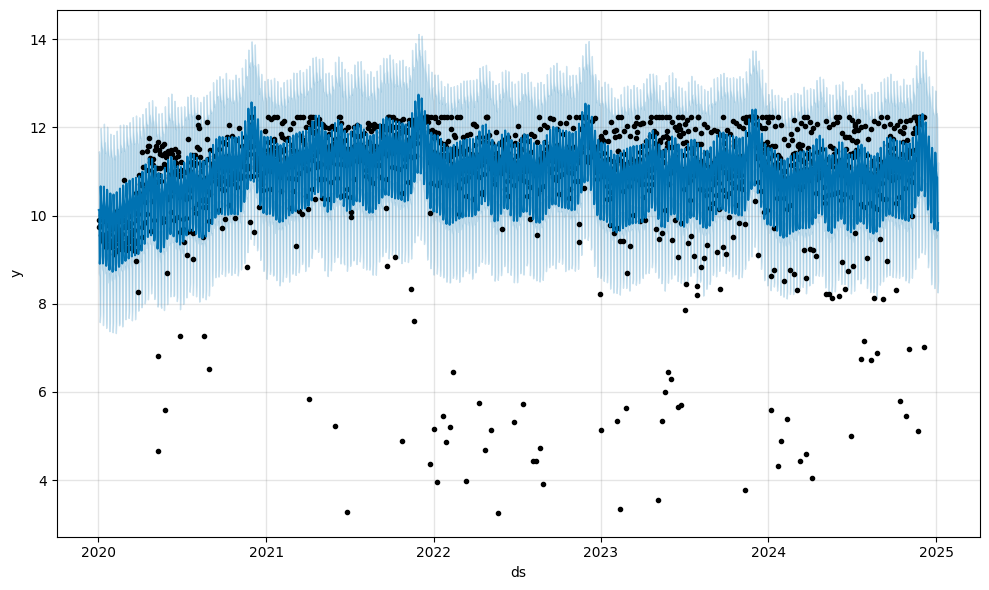

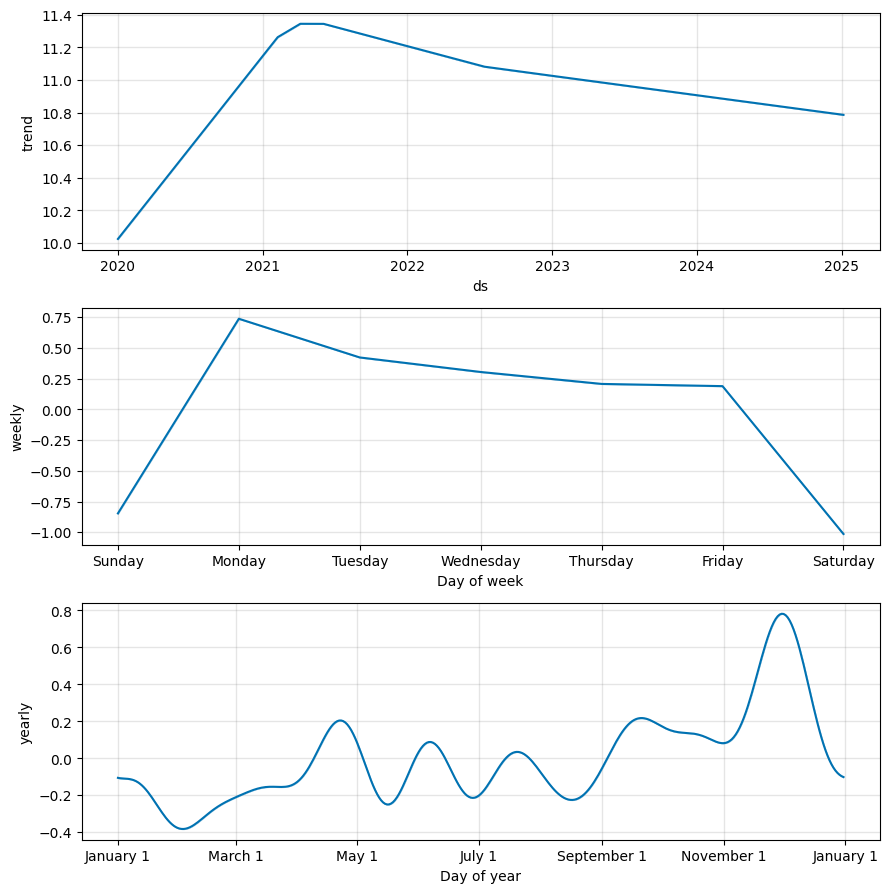

In [15]:
model.plot(forecast)
model.plot_components(forecast)
print(forecast)

In [16]:
daily_sales['y'] = daily_sales['y'].replace(0, np.nan)
daily_sales['y'] = daily_sales['y'].interpolate()  # Linear interpolation for missing/zero values

In [17]:
from sklearn.metrics import mean_squared_error
# Actual values
actual = daily_sales['y']

# Predicted values (match the dates to actual data)
predicted = forecast.loc[:len(actual)-1, 'yhat']

In [18]:
adjusted_actual = np.where(actual == 0, np.nan, actual)
mape = np.nanmean(np.abs((adjusted_actual - predicted) / adjusted_actual)) * 100
print(f"MAPE: {mape}%")

MAPE: 7.318017858286864%


In [19]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.0715303645738659


In [20]:
comparison = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
print(comparison.head(10))

      Actual  Predicted
0   9.891445  10.126371
1   9.752465  10.109648
2   9.760859   8.908299
3   9.769183   9.078104
4  10.003869  10.664977
5   9.561898  10.351974
6   9.446804  10.235026
7   9.587632  10.138381
8   9.417605  10.119609
9   9.448912   8.914168


In [21]:
from sklearn.model_selection import train_test_split
processed_data = daily_sales[['ds', 'y']].copy()

# Drop NaN values (if any)
processed_data.dropna(inplace=True)

In [22]:
test_size = 0.1

# Split the data
train_data, test_data = train_test_split(processed_data, test_size=test_size, shuffle=False)

In [23]:
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10)
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.fit(train_data.rename(columns={'ds': 'ds', 'y': 'y'}))

11:24:05 - cmdstanpy - INFO - Chain [1] start processing
11:24:06 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Forecast including the test range
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)

In [25]:
# Extract predictions for the test range
predicted_test = forecast.tail(len(test_data))

In [26]:
# Combine actual and predicted values for comparison
comparison_test = test_data.copy()
comparison_test['Predicted'] = predicted_test['yhat'].values

In [27]:
# Calculate evaluation metrics for the test set
actual_test = test_data['y']
predicted_test_values = predicted_test['yhat']

In [28]:
# Compute MAPE and RMSE for the test set
adjusted_actual_test = np.where(actual_test == 0, np.nan, actual_test)
mape_test = np.nanmean(np.abs((adjusted_actual_test - predicted_test_values) / adjusted_actual_test)) * 100
rmse_test = np.sqrt(mean_squared_error(actual_test, predicted_test_values))

In [29]:
print(f"Test MAPE: {mape_test}%")
print(f"Test RMSE: {rmse_test}")

Test MAPE: 8.38153524791552%
Test RMSE: 1.1993261588689728


In [30]:
print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 1620
Testing data length: 181


In [31]:
# Displaying the comparison
print(comparison_test.head(10))

             ds          y  Predicted
1620 2024-06-09   8.938694  10.261143
1621 2024-06-10  11.865967  11.667480
1622 2024-06-11  11.023601  11.354554
1623 2024-06-12  10.913052  11.237256
1624 2024-06-13  10.496855  11.131855
1625 2024-06-14  11.130130  11.098699
1626 2024-06-15  10.496129   9.789817
1627 2024-06-16   8.332097  10.133269
1628 2024-06-17  11.784141  11.522611
1629 2024-06-18  11.784523  11.195549
